In [1]:
try:
    %tensorflow_version 2.x
except:
    pass

In [2]:
import numpy as np
import matplotlib.pylab as plt

import os
import pathlib
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import Model
from tensorflow.keras import layers
from os import getcwd

In [3]:
'''
from google.colab import drive
drive.mount('/content/drive/')'''

"\nfrom google.colab import drive\ndrive.mount('/content/drive/')"

In [4]:
train_dir = '/content/drive/MyDrive/RiceLeafsData/train'
validation_dir = '/content/drive/MyDrive/RiceLeafsData/validation'

In [5]:
import os
classes=[]
for file in os.listdir(train_dir):
    classes+=[file]
print(classes)

['tungro', 'Hispa', 'Healthy', 'LeafBlast', 'blight', 'BrownSpot']


In [6]:
import PIL
from PIL import Image

for file in os.listdir(validation_dir):
  for content in os.listdir(validation_dir+'/'+file):
    f_img = validation_dir+"/"+file+"/"+content
    img = Image.open(f_img)
    img = img.resize((1500,1500))
    img.save(f_img)

print('finish')

finish


In [7]:
BATCH_SIZE = 32
IMG_WIDTH = 224
IMG_HEIGHT = 224

In [8]:


train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=25,
        vertical_flip=True,
        fill_mode = 'nearest',
        zoom_range=[0.5, 1.5]
        )

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT,IMG_WIDTH),
    class_mode='sparse'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT,IMG_WIDTH),
    class_mode='sparse'
)

Found 312 images belonging to 6 classes.
Found 168 images belonging to 6 classes.


In [9]:
path_inception = f"{getcwd()}/../content/drive/My Drive/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"


#create a instance of the onception model from the local pre-trained weights
local_weights_file = path_inception

pre_trained_model = tf.keras.applications.inception_v3.InceptionV3(input_shape = (224,224,3),
                                include_top = False)
pre_trained_model.load_weights(local_weights_file,by_name=True)

#make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  layer.trainable = False

# print the model summary
pre_trained_model.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)           

In [10]:
last_layer = pre_trained_model.get_layer('mixed10')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 5, 5, 2048)


In [11]:

# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
# Add a dropout rate of 0.2
x = tf.keras.layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = tf.keras.layers.Dense  (6, activation = 'softmax')(x)           

model = tf.keras.Model( pre_trained_model.input, x) 

model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0002, momentum=0.9),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


                                                                  'activation_14[0][0]',          
                                                                  'activation_17[0][0]',          
                                                                  'activation_18[0][0]']          
                                                                                                  
 conv2d_22 (Conv2D)             (None, 25, 25, 64)   18432       ['mixed1[0][0]']                 
                                                                                                  
 batch_normalization_22 (BatchN  (None, 25, 25, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 25, 25, 64)   0           ['batch_normalization_22[0][0]'] 
          

In [12]:
# Define a Callback class that stops training once accuracy reaches 99.0%
class myCallback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.99):
            print("\nReached 99.0% accuracy so cancelling training!")
            self.model.stop_training = True 

In [13]:
NUM_TRAINING_IMAGES = sum(len(files) for _, _, files in os.walk(train_dir))
NUM_VALIDATION_IMAGES = sum(len(files) for _, _, files in os.walk(validation_dir))

In [14]:
callbacks = myCallback()
EPOCHS = 50

# fit the model
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALIDATION_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE 
hist = model.fit(train_generator,
                 epochs=EPOCHS,
                 steps_per_epoch=STEPS_PER_EPOCH,
                 validation_steps = VALIDATION_STEPS,
                 validation_data=validation_generator)

Epoch 1/50
9/9 [==============================] - 201s 24s/step - loss: 2.1421 - accuracy: 0.2569 - val_loss: 1.4602 - val_accuracy: 0.3250
Epoch 2/50
9/9 [==============================] - 52s 6s/step - loss: 1.3059 - accuracy: 0.4536 - val_loss: 1.3011 - val_accuracy: 0.4437
Epoch 3/50
9/9 [==============================] - 52s 6s/step - loss: 1.0973 - accuracy: 0.5347 - val_loss: 1.2250 - val_accuracy: 0.5125
Epoch 4/50
9/9 [==============================] - 51s 6s/step - loss: 0.8816 - accuracy: 0.6464 - val_loss: 1.2668 - val_accuracy: 0.5188
Epoch 5/50
9/9 [==============================] - 52s 6s/step - loss: 0.8040 - accuracy: 0.6929 - val_loss: 1.0743 - val_accuracy: 0.6187
Epoch 6/50
9/9 [==============================] - 51s 6s/step - loss: 0.8873 - accuracy: 0.6143 - val_loss: 1.1321 - val_accuracy: 0.5938
Epoch 7/50
9/9 [==============================] - 51s 6s/step - loss: 0.7488 - accuracy: 0.7107 - val_loss: 1.0223 - val_accuracy: 0.5938
Epoch 8/50
9/9 [================

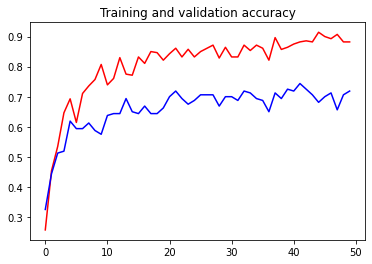

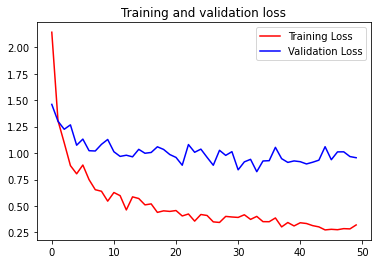

In [15]:
# Plot the model results
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)

Saving IMG_20190419_144414.jpg to IMG_20190419_144414.jpg
IMG_20190419_144414.jpg
[[0.0000000e+00 1.0000000e+00 6.6196960e-14 1.1757093e-10 1.3830120e-09
  1.9273744e-37]]


In [17]:
#save the model
model.save('my_model_detect.h5') 